In [1]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
import os

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.13.1


In [2]:
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()


train_images=np.expand_dims(train_images,axis=3)
train_images = train_images / 255.0

test_images=np.expand_dims(test_images,axis=3)
test_images = test_images / 255.0

train_labels = tf.keras.utils.to_categorical(train_labels, 10)
test_labels = tf.keras.utils.to_categorical(test_labels, 10)

In [3]:
IMAGE_SHAPE = [28, 28, 1]

inputs = tf.keras.Input(shape=(*IMAGE_SHAPE,))
x = tf.keras.layers.Conv2D(32, kernel_size=5, padding='SAME', activation=tf.nn.relu)(inputs)
x = tf.keras.layers.MaxPooling2D(
    pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x = tf.keras.layers.Conv2D(64, kernel_size=5, padding='SAME', activation=tf.nn.relu)(x)
x = tf.keras.layers.MaxPooling2D(
    pool_size=[2, 2], strides=[2, 2], padding="SAME")(x)
x = tf.keras.layers.Conv2D(128, kernel_size=5, padding='SAME', activation=tf.nn.relu)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.layers.Dense(
    84, activation=tf.nn.relu)(x)
x = tf.keras.layers.Dropout(0.4)(x)
predictions = tf.layers.Dense(10,activation=tf.nn.softmax)(x)

cnn = tf.keras.Model(inputs=inputs, outputs=predictions)


checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                 save_weights_only=True,
                                                 verbose=1)

cnn.compile(optimizer='adam', 
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=['accuracy'])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [4]:
train_cnn=False
if train_cnn:

    cnn.fit(train_images, train_labels, epochs=200,
          callbacks = [cp_callback])
else:
    cnn.load_weights(checkpoint_path)

In [5]:
test_loss, test_acc = cnn.evaluate(test_images, test_labels)



print('Test accuracy:', test_acc)

10000/10000 [==============================] - 5s 489us/sample - loss: 0.2063 - acc: 0.9872
Test accuracy: 0.9872


In [6]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        832       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        51264     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
flatten (Flatten)            (None, 6272)              0         
__________

In [7]:
class distiller(tf.keras.Model):
    
    def __init__(self, ext_model,lay_num, hidden_size=100):

        super(distiller, self).__init__()
        self.IMAGE_SHAPE  = [28, 28, 1]

        self.FILTER_SHAPE = ext_model.layers[lay_num].output.shape.as_list()[1:]

        self.ext_model_layers=ext_model.layers[:lay_num]
        for lay in self.ext_model_layers:
            lay.trainable = False
        
        self.ext_post_net=ext_model.layers[lay_num:]
        for lay in self.ext_post_net:
            lay.trainable = False
        
        #for layer in intermediate_layer_model.layers:
        #    layer.trainable = False


        self.rs = tf.keras.layers.Reshape([-1,np.prod(self.IMAGE_SHAPE)])
        self.hidden = tf.keras.layers.Dense(hidden_size, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(np.prod(self.FILTER_SHAPE), activation=tf.nn.relu)
        #self.dropout = tf.keras.layers.Dropout(0.5)
    


    def call(self, inputs, training=False):

        y=self.out(self.hidden(self.rs(inputs)))

        if training:
            y_ext = inputs
            for lay in self.ext_model_layers:
                y_ext = lay(y_ext)
            y_ext.reshape([-1,y_ext.output.shape.as_list()])
            return tf.math.subtract(t,y_ext)

        return y
    
    def mix_pred(self,inputs):
        
        y=self.out(self.hidden(self.rs(inputs)))
        y.reshape([-1,self.FILTER_SHAPE])
        for lay in self.ext_post_net:
                y = lay(y)
        return y



def loss(y_true,y_pred):
    return tf.mean_square_error(un[0], tf.zeros_like(y_true))

In [8]:
def training_generator(hidden_units,n_test, folder, n_epochs=100):
    #cnn.layers[1].output
    model = distiller(cnn, 5, hidden_size=hidden_units)
    opt=tf.train.AdamOptimizer()#learning_rate=0.01)# Cambiar a lr si se usa tf.keras
    model.compile(loss='mean_squared_error',
                  metrics=['mean_squared_error'],
                 optimizer=opt)

    checkpoint_path = folder+"training_distiller"+str(hidden_units)+"-"+str(n_test)+"/cp.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)

    cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                     save_weights_only=True,
                                                     verbose=0)
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    

    shape_out=np.prod(cnn.layers[5].output.shape.as_list()[1:])
    model.fit(train_images, 
              np.zeros([train_images.shape[0],shape_out]), 
              epochs=n_epochs,
              callbacks = [cp_callback],#,es_callback],
              verbose=0,)

    np.save(folder+"c5u"+str(hidden_units)+"-"+str(n_test),model.history.history['loss'])

# Visualization

attemp 0 with 50 units
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.train.CheckpointManager to manage checkpoints rather than manually editing the Checkpoint proto.
attemp 1 with 50 units
attemp 2 with 50 units
attemp 3 with 50 units
attemp 4 with 50 units
attemp 0 with 150 units
attemp 1 with 150 units
attemp 2 with 150 units
attemp 3 with 150 units
attemp 4 with 150 units
attemp 0 with 200 units
attemp 1 with 200 units
attemp 2 with 200 units
attemp 3 with 200 units
attemp 4 with 200 units
attemp 0 with 250 units
attemp 1 with 250 units
attemp 2 with 250 units
attemp 3 with 250 units
attemp 4 with 250 units
attemp 0 with 300 units
attemp 1 with 300 units
attemp 2 with 300 units
attemp 3 with 300 units
attemp 4 with 300 units
attemp 0 with 350 units
attemp 1 with 350 units
attemp 2 with 350 units
attemp 3 with 350 units
attemp 4 with 350 units
attemp 0 with 400 units
attemp 1 with 400 units
attemp 2 w

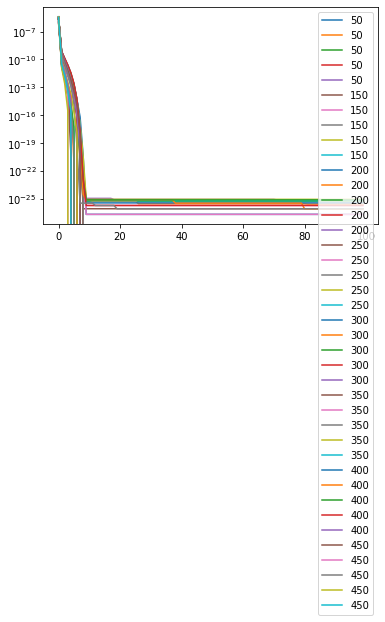

In [9]:
#units = [10, 100, 500, 780, 790, 1000, 5000, 10000]
units = [50,150,200,250,300,350,400,450]
n_exp = 5
plt.figure()
folder="exp3/"
msg ="attemp %n with %j units"

n_epochs = 100
for hidden_units in units:
    for i in range(n_exp):
        print(msg.replace("%n",str(i)).replace("%j",str(hidden_units)))
        training_generator(hidden_units, i, folder, n_epochs=n_epochs)
        plt.semilogy(
            np.load(folder + "c5u" + str(hidden_units) + "-" + str(i) + ".npy"),
            label=str(hidden_units),
        )
        plt.legend()
        plt.savefig(folder + "loss_plot.png")